# Predictive Modeling #

In [ ]:
#Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Load data
df = pd.read_json('/content/ultimate_data_challenge.json')
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [ ]:
df.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000


In [ ]:
df.dtypes

city                       object
trips_in_first_30_days      int64
signup_date                object
avg_rating_of_driver      float64
avg_surge                 float64
last_trip_date             object
phone                      object
surge_pct                 float64
ultimate_black_user          bool
weekday_pct               float64
avg_dist                  float64
avg_rating_by_driver      float64
dtype: object

In [ ]:
#Impute values and fix data types
df.avg_rating_of_driver = df.avg_rating_of_driver.fillna(df.avg_rating_of_driver.mean())
df.avg_rating_by_driver = df.avg_rating_by_driver.fillna(df.avg_rating_by_driver.mean())

In [ ]:
#Clean up data types
df.city = df.city.astype('category')
df.phone = df.phone.astype('category')
df.ultimate_black_user = df.ultimate_black_user.astype('category')
df.signup_date = pd.to_datetime(df.signup_date, errors='coerce')
df.last_trip_date = pd.to_datetime(df.last_trip_date, errors='coerce')

In [ ]:
#Create dummy variables
df = pd.get_dummies(df)
df.head()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True
0,4,2014-01-25,4.7,1.10,2014-06-17,15.4,46.2,3.67,5.0,0,1,0,0,1,0,1
1,0,2014-01-29,5.0,1.00,2014-05-05,0.0,50.0,8.26,5.0,1,0,0,1,0,1,0
2,3,2014-01-06,4.3,1.00,2014-01-07,0.0,100.0,0.77,5.0,1,0,0,0,1,1,0
3,9,2014-01-10,4.6,1.14,2014-06-29,20.0,80.0,2.36,4.9,0,1,0,0,1,0,1
4,14,2014-01-27,4.4,1.19,2014-03-15,11.8,82.4,3.13,4.9,0,0,1,1,0,1,0


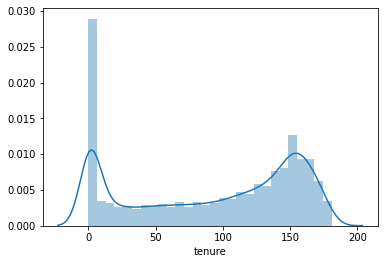

In [ ]:
#Calculate tenure from signup date to last trip
df['tenure'] = (df.last_trip_date - df.signup_date).dt.days
sns.distplot(df.tenure)

In [ ]:
#Calculate target variable
df['target'] = np.where(df.tenure >= 150, 1,0)
df.target.value_counts()

0    37286
1    12714
Name: target, dtype: int64

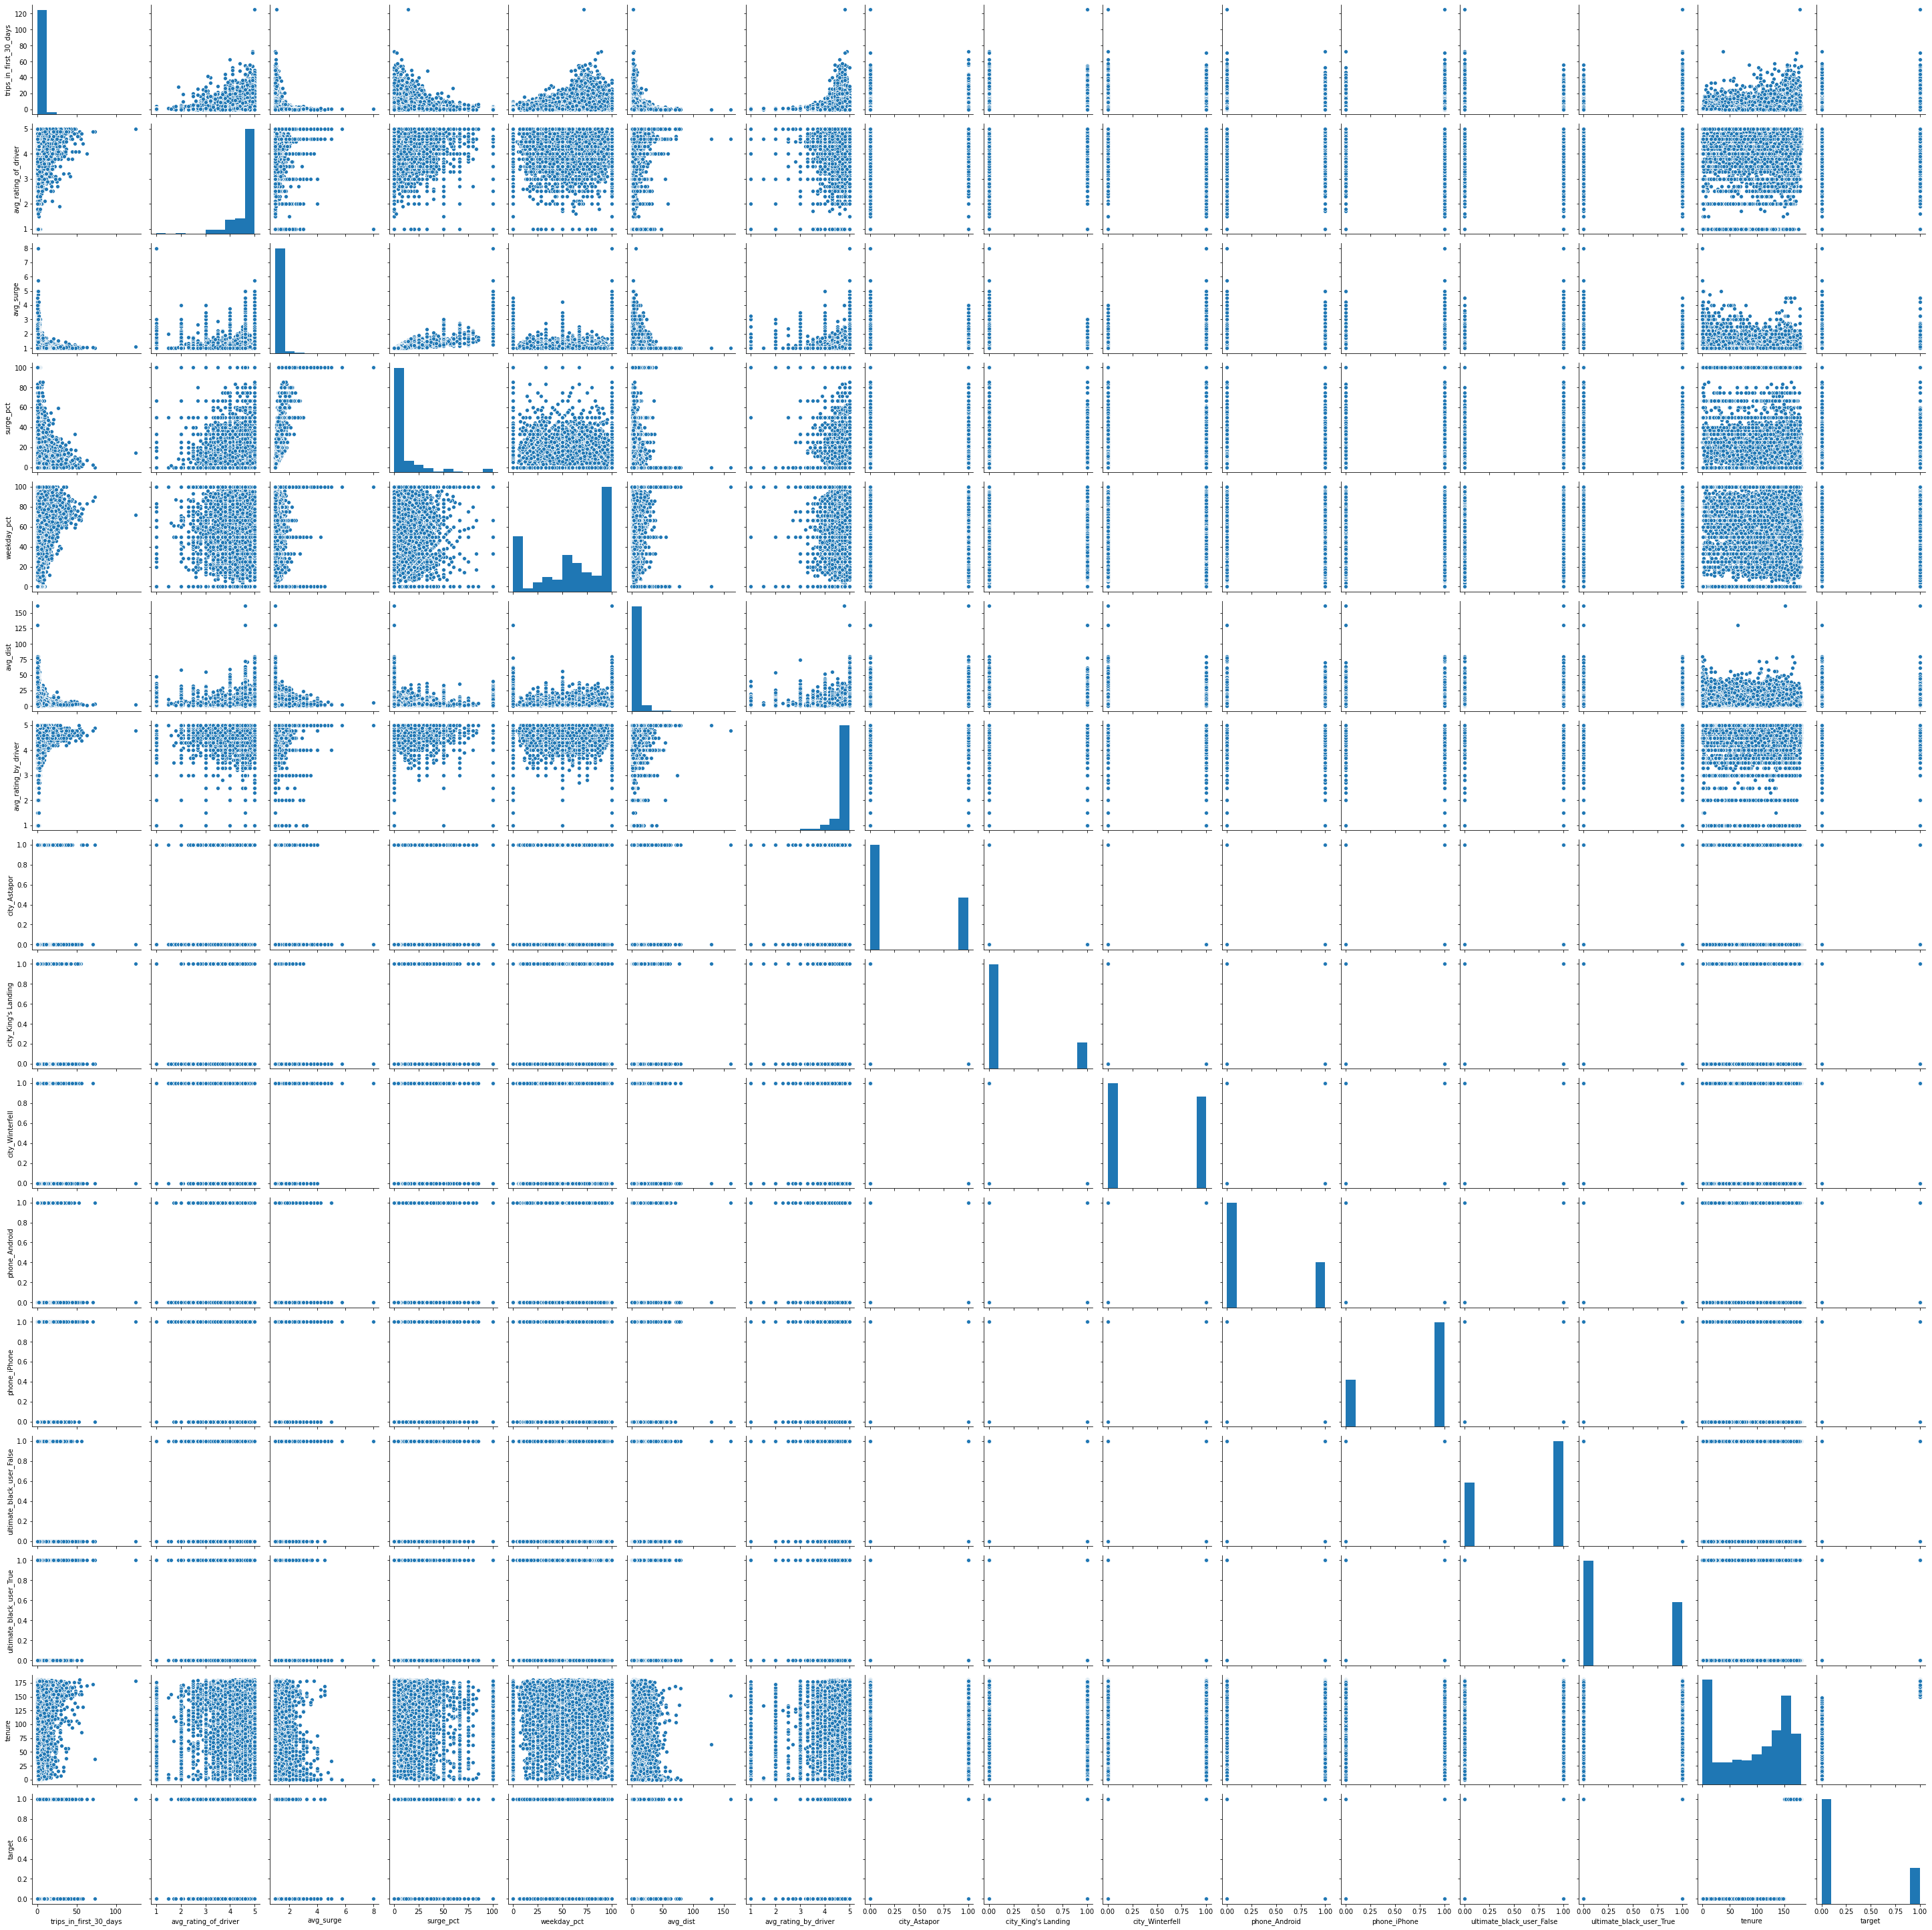

In [ ]:
#Explore data with pairplots
sns.pairplot(df)
plt.savefig("Raw Data - Seaborn Pairplot.png")
plt.show()

In [ ]:
#Explore data with correlation matrix
df.corr()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor,city_King's Landing,city_Winterfell,phone_Android,phone_iPhone,ultimate_black_user_False,ultimate_black_user_True,tenure,target
trips_in_first_30_days,1.000000,-0.011060,-0.001841,0.005720,0.050388,-0.136329,-0.039097,-0.061075,0.024650,0.037735,-0.059309,0.058342,-0.112210,0.112210,0.164784,0.210011
avg_rating_of_driver,-0.011060,1.000000,-0.021653,-0.003290,0.012587,0.028508,0.101660,0.029814,0.082156,-0.094304,0.024206,-0.024323,0.001916,-0.001916,-0.015183,-0.007991
avg_surge,-0.001841,-0.021653,1.000000,0.793582,-0.110071,-0.081491,0.010498,0.037172,-0.009198,-0.027643,-0.008977,0.011104,0.078791,-0.078791,-0.016809,0.006780
surge_pct,0.005720,-0.003290,0.793582,1.000000,-0.144918,-0.104414,0.019964,0.045457,0.028221,-0.065603,-0.010150,0.012851,0.106861,-0.106861,0.004068,0.017825
weekday_pct,0.050388,0.012587,-0.110071,-0.144918,1.000000,0.101652,0.020366,-0.010540,0.031349,-0.015318,-0.009241,0.006726,-0.035998,0.035998,0.020408,0.007811
avg_dist,-0.136329,0.028508,-0.081491,-0.104414,0.101652,1.000000,0.079793,-0.045431,0.015877,0.030050,0.020888,-0.025030,-0.032310,0.032310,-0.109431,-0.092038
avg_rating_by_driver,-0.039097,0.101660,0.010498,0.019964,0.020366,0.079793,1.000000,0.032518,0.084480,-0.098727,0.008765,-0.010127,-0.009328,0.009328,-0.032651,-0.021399
city_Astapor,-0.061075,0.029814,0.037172,0.045457,-0.010540,-0.045431,0.032518,1.000000,-0.354298,-0.657563,0.025642,-0.024539,-0.021259,0.021259,-0.119001,-0.134652
city_King's Landing,0.024650,0.082156,-0.009198,0.028221,0.031349,0.015877,0.084480,-0.354298,1.000000,-0.471555,-0.059203,0.060520,-0.039649,0.039649,0.193598,0.187189
city_Winterfell,0.037735,-0.094304,-0.027643,-0.065603,-0.015318,0.030050,-0.098727,-0.657563,-0.471555,1.000000,0.023517,-0.025618,0.051990,-0.051990,-0.043755,-0.023833


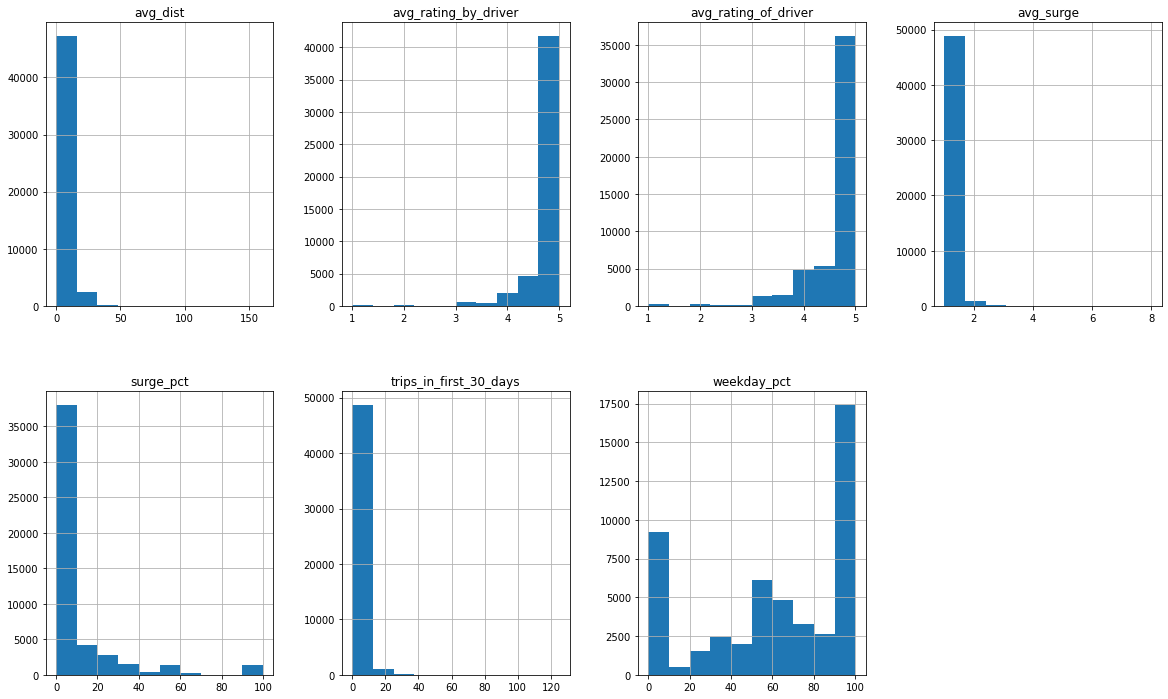

In [ ]:
#Examine distribution of numerical columns
cols = [
    'trips_in_first_30_days',
    'avg_rating_of_driver',
    'avg_surge',
    'surge_pct',
    'weekday_pct',
    'avg_dist',
    'avg_rating_by_driver'
]
fig = df[cols].hist(layout = (2,4), figsize = (20,12))
plt.savefig('Histograms of Numerical Data.png')
plt.show()

In [ ]:
#Drop original dates
df = df.drop(['signup_date','last_trip_date'], axis=1)

In [ ]:
#Import packages for scaling, test-train split, and logistic regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#Train-test split and scaling
X = df.drop(['tenure','target'],axis=1)
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

In [ ]:
clf = LogisticRegression(random_state=42)
clf.fit(X_scaled,y_train)
X_test_scaled = scaler.fit_transform(X_test)
clf.score(X_test_scaled,y_test)

0.7609

In [ ]:
coefs_df = pd.DataFrame(clf.coef_, columns = list(df.columns)[:14]).transpose()
coefs_df

,0
trips_in_first_30_days,0.383663
avg_rating_of_driver,-0.017258
avg_surge,-0.023370
surge_pct,0.088409
weekday_pct,-0.001652
avg_dist,-0.222995
avg_rating_by_driver,-0.053957
city_Astapor,-0.241599
city_King's Landing,0.300980
city_Winterfell,-0.014037


From this model, we have an accuracy score of .7609 and a good understanding of which features most significantly contribute to a user continuing to order rides in their 6th month of activity and beyond.

Recently, I've been playing around with a model-comparison library called PyCaret. I like this package because it provides a quick comparison of several classification or regression models. We can potentially use this image to consider other model types. 

In [ ]:
%pip install pycaret
%pip install shap

In [49]:
from pycaret.classification import *

In [50]:
df = df.drop('tenure', axis=1)

KeyError: ignored

In [53]:
setup(df, 'target', 
      train_size=0.8, 
      normalize=True, 
      normalize_method='minmax',
      categorical_features = ['city_Astapor','city_King\'s Landing','city_Winterfell','phone_Android','phone_iPhone','ultimate_black_user_False','ultimate_black_user_True'], 
      fix_imbalance=True)

Setup Succesfully Completed!


,Description,Value
0,session_id,6984
1,Target Type,Binary
2,Label Encoded,"0: 0, 1: 1"
3,Original Data,"(50000, 15)"
4,Missing Values,False
5,Numeric Features,7
6,Categorical Features,7
7,Ordinal Features,False
8,High Cardinality Features,False
9,High Cardinality Method,None


(       trips_in_first_30_days  ...  ultimate_black_user_True_1
 0                       0.032  ...                         1.0
 1                       0.000  ...                         0.0
 2                       0.024  ...                         0.0
 3                       0.072  ...                         1.0
 4                       0.112  ...                         0.0
 ...                       ...  ...                         ...
 49995                   0.000  ...                         0.0
 49996                   0.008  ...                         0.0
 49997                   0.000  ...                         1.0
 49998                   0.016  ...                         0.0
 49999                   0.000  ...                         0.0
 
 [50000 rows x 21 columns], 0        0
 1        0
 2        0
 3        1
 4        0
         ..
 49995    0
 49996    0
 49997    0
 49998    0
 49999    0
 Name: target, Length: 50000, dtype: int64,        trips_in_first_30_da

In [54]:
model = compare_models(verbose=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,CatBoost Classifier,0.7922,0.8206,0.5404,0.6021,0.5694,0.4329,0.4342,27.3076
1,Light Gradient Boosting Machine,0.7902,0.8230,0.5670,0.5914,0.5788,0.4392,0.4395,0.8232
2,Gradient Boosting Classifier,0.7754,0.8199,0.6384,0.5504,0.5910,0.4374,0.4397,10.5076
3,Extreme Gradient Boosting,0.7745,0.8196,0.6398,0.5487,0.5907,0.4363,0.4389,3.4007
4,Ada Boost Classifier,0.7657,0.8092,0.6600,0.5319,0.5890,0.4278,0.4327,2.8140
5,Random Forest Classifier,0.7500,0.7612,0.5138,0.5084,0.5110,0.3431,0.3432,0.6277
6,Extra Trees Classifier,0.7472,0.7711,0.5959,0.5025,0.5452,0.3719,0.3745,4.6316
7,Decision Tree Classifier,0.7074,0.6364,0.4928,0.4339,0.4613,0.2616,0.2627,0.5264
8,K Neighbors Classifier,0.7061,0.7422,0.6633,0.4475,0.5344,0.3313,0.3450,0.6506
9,Logistic Regression,0.6794,0.7331,0.6592,0.4175,0.5112,0.2902,0.3070,1.0322


In [55]:
model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8002,0.8293,0.5959,0.6097,0.6027,0.4693,0.4694
1,0.7850,0.8188,0.5683,0.5786,0.5734,0.4297,0.4297
2,0.7872,0.8211,0.5575,0.5857,0.5713,0.4299,0.4302
3,0.7952,0.8283,0.5782,0.6012,0.5895,0.4532,0.4533
4,0.7867,0.8190,0.5762,0.5813,0.5788,0.4360,0.4360
5,0.7860,0.8245,0.5654,0.5814,0.5733,0.4305,0.4306
6,0.7852,0.8228,0.5418,0.5837,0.5620,0.4200,0.4205
7,0.7915,0.8256,0.5762,0.5925,0.5842,0.4451,0.4452
8,0.7808,0.8065,0.5536,0.5710,0.5622,0.4160,0.4161
9,0.8038,0.8342,0.5570,0.6293,0.5909,0.4625,0.4640


In [56]:
model = tune_model(model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8055,0.8295,0.5615,0.6323,0.5948,0.4674,0.4689
1,0.7817,0.8179,0.5408,0.5753,0.5575,0.4129,0.4132
2,0.7890,0.8196,0.5310,0.5954,0.5613,0.4230,0.4242
3,0.7910,0.8232,0.5467,0.5972,0.5708,0.4331,0.4338
4,0.7912,0.8155,0.5467,0.5978,0.5711,0.4336,0.4343
5,0.7882,0.8196,0.5290,0.5938,0.5595,0.4208,0.4220
6,0.7825,0.8190,0.5054,0.5834,0.5416,0.4000,0.4018
7,0.7920,0.8199,0.5546,0.5981,0.5755,0.4380,0.4386
8,0.7820,0.8068,0.5428,0.5756,0.5587,0.4141,0.4144
9,0.8065,0.8313,0.5324,0.6452,0.5834,0.4589,0.4625


In [57]:
predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7952,0.8234,0.5529,0.6068,0.5786,0.4437,0.4446


,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,city_Astapor_0,city_Astapor_1,city_Kings Landing_0,city_Kings Landing_1,city_Winterfell_0,city_Winterfell_1,phone_Android_0,phone_Android_1,phone_iPhone_0,phone_iPhone_1,ultimate_black_user_False_0,ultimate_black_user_False_1,ultimate_black_user_True_0,ultimate_black_user_True_1,target,Label,Score
0,0.016,1.00000,0.000000,0.0,1.000,0.060077,1.00,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0.2806
1,0.000,0.92500,0.000000,0.0,0.429,0.016029,1.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0,0,0.1455
2,0.008,0.75000,0.000000,0.0,1.000,0.039389,1.00,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0,0,0.0283
3,0.072,0.70000,0.000000,0.0,1.000,0.045912,0.95,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0.3207
4,0.008,1.00000,0.000000,0.0,1.000,0.046906,1.00,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0,0,0.1432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.000,0.90039,0.000000,0.0,0.000,0.035475,0.75,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0.2249
9996,0.016,1.00000,0.000000,0.0,1.000,0.009505,1.00,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0.0785
9997,0.016,1.00000,0.000000,0.0,0.333,0.010065,1.00,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0,0,0.1104
9998,0.008,1.00000,0.142857,1.0,0.000,0.015159,1.00,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1,0,0.1128


The Light Gradient Boosting model is  more accurate than Logistic Regression, and PyCaret provides useful visualizations on feature importance, AUC, etc. Both models underscore the importance of a user's activity in their first 30 days, but the the LGBoost model paints a picture of the user's experience - their rating, distance traveled, and the driver's rating - as important features as well. Given its accuracy, I would recommend incentives around frequent, long trips in the first 30 days in order to increase affinity.

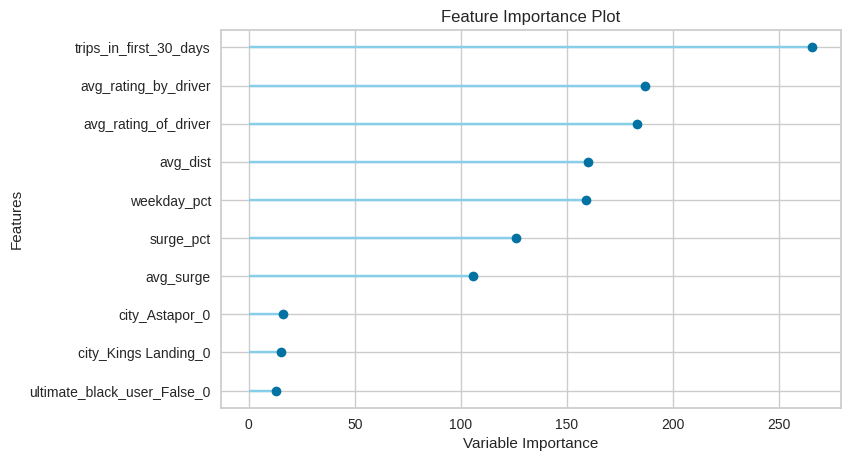

In [58]:
plot_model(model, plot='feature', verbose=True)

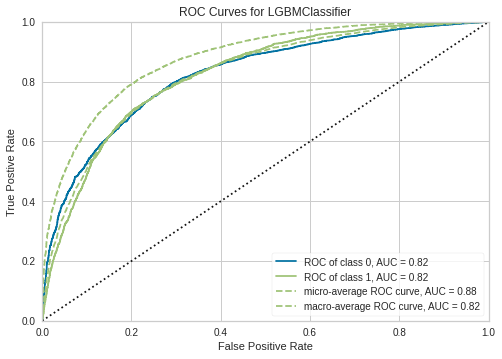

In [59]:
plot_model(model, plot='auc', verbose=True)

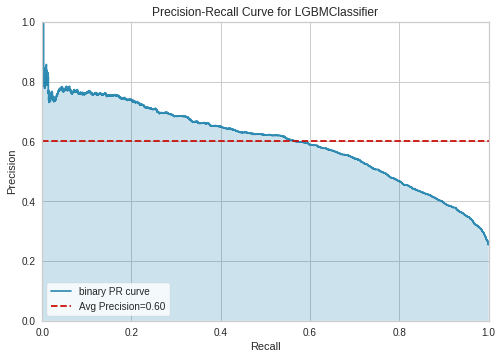

In [60]:
plot_model(model, plot='pr', verbose=True)